In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import silhouette_score
import gower

In [2]:
color_blue_light = "deepskyblue"
color_blue_vivid = "royalblue"
color_green = "mediumseagreen"
color_pink = "hotpink"
color_gold = "gold"
color_purple = "mediumorchid"
color_orange = "darkorange"
color_mint = "mediumaquamarine"
color_lavender = "blueviolet"
color_sky = "cadetblue"
color_rose = "lightcoral"
color_red = "indianred"
color_black = "black"
color_white = "white"


In [3]:
df = pd.read_csv("data/df_grouped.csv")


# === FASE 1: DATA PREPROCESSING ===

In [4]:
# Select relevant columns
cols_to_use = ["Indice di spopolamento","Indice di occupazione",
          "Indice disoccupazione","Tipo di località_Altri comuni non altrimenti classificati",
          "Tipo di località_Capoluogo senza specifici interessi turistici","Tipo di località_Città d\'Arte",
          "Tipo di località_Località collinari","Tipo di località_Località lacuali",
          "Tipo di località_Località marine","Tipo di località_Località montane",
          "Tipo di località_Località religiose","Tipo di località_Località termali", 
          "PC_Economica","PC_Turistica_1","PC_Turistica_2", "PC_Turistica_3", "PC_Turistica_4", 
          "PC_Turistica_5", "PC_Turistica_6", "PC_Turistica_7", "PC_Turistica_8", "PC_Turistica_9", 
          "PC_Turistica_10", "PC_Turistica_11", "PC_Turistica_12", "Macroarea_Isole", "Macroarea_Nord", 
          "Macroarea_Sud","Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_signorili", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_tipiche_dei_luoghi",
          "Descrizione_Tipologia_di_Immobile_Ville_e_Villini"]
data = df[cols_to_use].copy()


In [5]:
print("Controllo valori NaN nel dataset:")
print(f"Righe totali: {len(data)}")
print(f"Righe con NaN: {data[cols_to_use].isnull().any(axis=1).sum()}")

# Identifichiamo quali righe hanno NaN (per curiosità)
righe_con_nan = data[cols_to_use].isnull().any(axis=1)
if righe_con_nan.sum() > 0:
    print(f"Indici delle righe con NaN: {data[righe_con_nan].index.tolist()}")

# Rimuoviamo le righe con valori NaN
data_clean = data[cols_to_use].dropna()
print(f"Righe dopo pulizia: {len(data_clean)}")
print(f"Percentuale di dati mantenuti: {len(data_clean)/len(data)*100:.2f}%")

# Ora procediamo con la standardizzazione sui dati puliti
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_clean)

print(f"Forma dei dati standardizzati: {X_scaled.shape}")
print(f"Numero di feature utilizzate: {len(cols_to_use)}")

Controllo valori NaN nel dataset:
Righe totali: 8182
Righe con NaN: 3
Indici delle righe con NaN: [147, 1523, 8181]
Righe dopo pulizia: 8179
Percentuale di dati mantenuti: 99.96%
Forma dei dati standardizzati: (8179, 32)
Numero di feature utilizzate: 32


# === FASE 2: DETERMINAZIONE DEL NUMERO OTTIMALE DI CLUSTER ===


In [6]:

# Liste per salvare i risultati di ogni tentativo
inertias = []           # "Costo" interno di ogni clustering (analogo al cost di K-prototypes)
silhouette_scores = []  # Misura di quanto sono ben separati i cluster
k_values = []           # I valori di K che stiamo testando

# Definiamo il range di K da testare
k_range = range(2, 13)  # Da 2 a 12 cluster (stesso range del tuo codice originale)

print("Testando diversi numeri di cluster...")
print("-" * 50)

for k in k_range:
    # Creiamo il modello K-means
    # random_state=42 garantisce risultati riproducibili
    # init='k-means++' è una strategia di inizializzazione intelligente
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    
    # Eseguiamo il clustering
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calcoliamo l'inerzia (somma delle distanze al quadrato dai centroidi)
    # Questa è l'equivalente del "cost" in K-prototypes
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    # Calcoliamo il silhouette score
    # Questo misura quanto sono ben definiti e separati i cluster
    sil_score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(sil_score)
    
    # Salviamo il valore di K
    k_values.append(k)
    
    # Stampiamo i risultati (come nel tuo codice originale)
    print(f"K={k}, Inerzia={inertia:.2f}, Silhouette Score={sil_score:.4f}")


Testando diversi numeri di cluster...
--------------------------------------------------
K=2, Inerzia=243800.26, Silhouette Score=0.2136
K=3, Inerzia=227353.63, Silhouette Score=0.1022
K=4, Inerzia=214579.46, Silhouette Score=0.1279
K=5, Inerzia=205614.88, Silhouette Score=0.1448
K=6, Inerzia=198039.65, Silhouette Score=0.1928
K=7, Inerzia=189520.11, Silhouette Score=0.1942
K=8, Inerzia=181099.31, Silhouette Score=0.2100
K=9, Inerzia=171822.97, Silhouette Score=0.2303
K=10, Inerzia=163204.30, Silhouette Score=0.2341
K=11, Inerzia=154799.38, Silhouette Score=0.2491
K=12, Inerzia=146279.84, Silhouette Score=0.2505


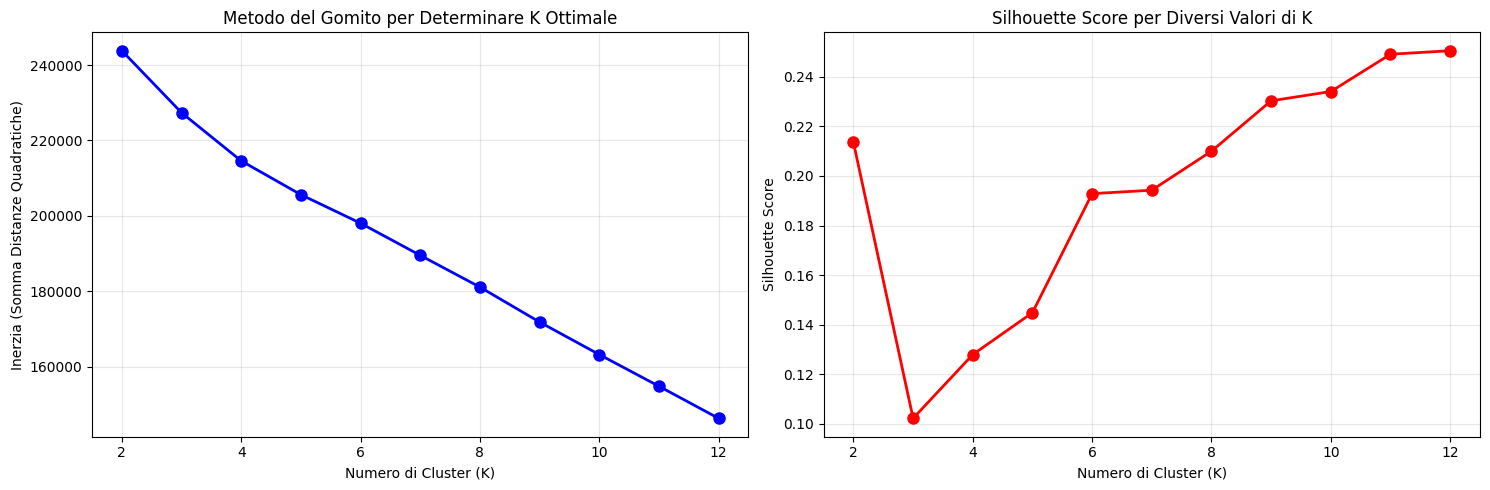

In [7]:
# === FASE 3: VISUALIZZAZIONE DEI RISULTATI ===

# Creiamo due grafici per analizzare i risultati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafico 1: Metodo del Gomito (Elbow Method)
ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Numero di Cluster (K)')
ax1.set_ylabel('Inerzia (Somma Distanze Quadratiche)')
ax1.set_title('Metodo del Gomito per Determinare K Ottimale')
ax1.grid(True, alpha=0.3)

# Grafico 2: Silhouette Score
ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Numero di Cluster (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score per Diversi Valori di K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# === FASE 4: SUGGERIMENTI PER LA SCELTA DEL K OTTIMALE ===

# Troviamo il K con il miglior silhouette score
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("\n" + "="*60)
print("ANALISI DEI RISULTATI")
print("="*60)
print(f"K con miglior Silhouette Score: {best_k_silhouette} (score: {best_silhouette:.4f})")
print(f"Range Silhouette Scores: {min(silhouette_scores):.4f} - {max(silhouette_scores):.4f}")

print("\nCome interpretare i risultati:")
print("- Cerca il 'gomito' nel primo grafico (dove la curva si appiattisce)")
print("- Preferisci K con Silhouette Score più alto (idealmente > 0.3)")
print("- Considera anche il senso pratico: troppi cluster potrebbero essere difficili da interpretare")


ANALISI DEI RISULTATI
K con miglior Silhouette Score: 12 (score: 0.2505)
Range Silhouette Scores: 0.1022 - 0.2505

Come interpretare i risultati:
- Cerca il 'gomito' nel primo grafico (dove la curva si appiattisce)
- Preferisci K con Silhouette Score più alto (idealmente > 0.3)
- Considera anche il senso pratico: troppi cluster potrebbero essere difficili da interpretare


In [14]:
# === FASE 5: ESECUZIONE DEL CLUSTERING FINALE ===

# Scegli il tuo K ottimale basandoti sui grafici sopra
optimal_k = 6 # iniziamo con 8 ma si può cambiare a 6 o 10 in base ai risultati

# Esegui il clustering finale
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
final_clusters = final_kmeans.fit_predict(X_scaled)

# Aggiungi i risultati al dataframe pulito (senza NaN)
data_clean['Cluster'] = final_clusters

print(f"\nClustering completato con K={optimal_k}")
print(f"Distribuzione dei cluster:")
print(data_clean['Cluster'].value_counts().sort_index())


Clustering completato con K=6
Distribuzione dei cluster:
Cluster
0    1610
1    3551
2    1254
3     536
4     379
5     849
Name: count, dtype: int64
